In [1]:
import cv2
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar

from thinning import zhangSuen
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

In [2]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [3]:
def getHist(img, axes=0):
    hist = []
    if axes == 0:
        for i in range(img.shape[1]):
            hist.append(np.sum(img[:, i]))
    else:
        for i in range(img.shape[0]):
            hist.append(np.sum(img[i, :]))
            
    return np.array(hist)

In [4]:
def showHist(hist):
    plt.figure()
    bar(np.arange(len(hist)), hist, width=0.8, align='center')

In [5]:
def thin(img):
    img = np.invert(img)
    
    Otsu_Threshold = threshold_otsu(img)
    thresholded = img < Otsu_Threshold    # must set object region as 1, background region as 0 !

    return zhangSuen(thresholded)

In [6]:
def toSkeleton(img):
    binary = img.copy()
    binary[binary <= 127] = 0
    binary[binary > 127] = 1
    return (skeletonize(binary) + 0)

In [7]:
def breakLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)

    ## (3) minAreaRect on the nozeros
    H,W = img.shape[:2]
    (cx,cy), (w,h), ang = ret
    
    if (H > W and w > h) or (H < W and w < h):
        w,h = h,w
        ang += 90

    # ## (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))
    
    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]
    
    uppers_mod = [uppers[0]]
    lowers_mod = [lowers[0]]
    
    for i in range(1, len(uppers)):
        if (lowers[i] - lowers[i-1]) > 10:
            uppers_mod.append(uppers[i])
            lowers_mod.append(lowers[i])

    lines = []
    if len(uppers_mod) == len(lowers_mod):
        for i in range(len(uppers_mod)):
            lines.append(rotated[uppers_mod[i]-5:lowers_mod[i]+5, :])

    return lines

In [62]:
def breakWords(line):
    H, W = line.shape
    hist = cv2.reduce(line, 0, cv2.REDUCE_AVG).reshape(-1)

    lefts = []
    rights = []
    
    start = False
    count = 0
    possible_end = 0
    for i in range(len(hist)):
        if hist[i] != 0 and start:
            count = 0

        if hist[i] == 0 and start:
            if count == 0:
                possible_end = i
            if count >= 3:
                count = 0
                start = False
                rights.append(possible_end)
            count = count + 1
    
        if hist[i] != 0 and not start:
            start = True
            lefts.append(i)

    words = []
    if len(lefts) == len(rights):
        for i in range(len(rights)):
            words.append(line[:, lefts[i]:rights[i]])

    return words

In [9]:
def extractTemplate(template, isSkeleton=True):
    if not isSkeleton:
        template = toSkeleton(template)
    template = template[~np.all(template == 0, axis=1)]
    mask = (template == 0).all(0)
    template = template[:, ~mask]
    
    return template

In [10]:
def templateMatch(skeleton, template, threshold=0.4, start=False):
    if template.shape[0] > skeleton.shape[0] or template.shape[1] > skeleton.shape[1]:
        return 0
    
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(skeleton.astype(np.uint8), template.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    for pt in zip(*loc[::-1]):
        if start:
            return pt[0]
        return pt[0] + w

    return 0

In [11]:
def getBaseLine(word):
    skeleton = toSkeleton(word)
    
    hist = []
    for i in range(word.shape[0]):
        hist.append(np.sum(word[i, :]))

    baseLine = np.where(hist == np.max(hist))[0][0]
    return baseLine

In [12]:
def addEmptySpaceSep(hist):
    splitters = []
    notEmpty = False
    for i in range(len(hist)):
        if notEmpty and hist[i] == 0:
            splitters.append(i)
            notEmpty = False

        if hist[i] != 0:
            notEmpty = True
            
    return np.array(splitters)

In [13]:
def isFakeAlef(word, splitter):
    start = 0
    for i in range(word.shape[1]):
        if np.sum(word[:, i]) > 0:
            start = i
            break
    subWord = word[:, start:splitter]
    
    if subWord.shape[1] > 3:
        return False
    for i in range(subWord.shape[1]):
        column = subWord[:, i]
        indecies = np.where(column > 0)[0]
        
        if len(indecies) > 1 and (abs(indecies[-1] - indecies[0]) > 3):
            return False
        
    return True

In [14]:
sen = (cv2.imread("./templates/sen_template.png", 0) / 255).astype(np.uint8)
yStart = (cv2.imread("./templates/y_template.png", 0) / 255).astype(np.uint8)
senStart = (cv2.imread("./templates/sen_start_template.png", 0) / 255).astype(np.uint8)
senMiddle = (cv2.imread("./templates/sen_middle_template.png", 0) / 255).astype(np.uint8)
hStart = (cv2.imread("./templates/7_template.png", 0) / 255).astype(np.uint8)
shenMiddle = (cv2.imread("./templates/shen_middle_template.png", 0) / 255).astype(np.uint8)

In [15]:
def matchFirstCharacter(word):
    yStart = (cv2.imread("./templates/y_template.png", 0) / 255).astype(np.uint8)
    senStart = (cv2.imread("./templates/sen_start_template.png", 0) / 255).astype(np.uint8)
    hStart = (cv2.imread("./templates/7_template.png", 0) / 255).astype(np.uint8)

    skeleton = toSkeleton(word)
    firstSenSep = templateMatch(skeleton, senStart, threshold=0.55)
    firstYSep = templateMatch(skeleton, yStart, threshold=0.8)
    firstHSep = templateMatch(skeleton, hStart, threshold=0.5)
    
    firstSep = 0
    if firstSenSep != 0:
        firstSep = firstSenSep
    elif firstYSep != 0:
        firstSep = firstYSep
    elif firstHSep != 0:
        firstSep = firstHSep
        
    return firstSep

In [74]:
def segmenteCharacters(word, to_skeleton=True, debug=False):
    full_skeleton = toSkeleton(word) if to_skeleton else word
    skeleton = toSkeleton(word) if to_skeleton else word
    base_line = getBaseLine(skeleton)
    splitters = np.array([]).astype(np.uint8)

    first_sep = matchFirstCharacter(word)
    if first_sep >= word.shape[1]:
        return [full_skeleton]

    if first_sep != 0:
        splitters = np.append(splitters, first_sep)
        word = word[:, first_sep:]
        skeleton = toSkeleton(word)

    full_hist = getHist(skeleton)
    hist = getHist(skeleton[0:base_line-1, :])
    diff = np.diff(hist)

    # add splitters at the start of region that doesn't contain pixels
    empty_space_splitters = addEmptySpaceSep(full_hist) + first_sep
    splitters = np.append(np.array(splitters), empty_space_splitters)

    # add splitter at point if you were above base line and return back to baseline
    base_line_splitters = [(i + first_sep) for i in range(1, len(diff))
                           if (diff[i-1] != 0 and diff[i] == 0 and hist[i] == 0)]
    splitters = np.append(splitters, base_line_splitters).astype(np.uint8)
    splitters.sort()    # sort splitters in ascending order

    if len(splitters) == 0:
        return [full_skeleton]

    start = 2 if len(
        splitters) > 1 and splitters[1] - splitters[0] <= 3 and splitters[1] in empty_space_splitters else 1
    mod_splitters = np.array(
        [splitters[1] if start == 2 else splitters[0]]).astype(np.uint8)
    real_splitters = [splitters[i] for i in range(
        start, len(splitters)) if splitters[i] - splitters[i-1] > 3]
    mod_splitters = np.append(mod_splitters, real_splitters).astype(np.uint8)

    if len(mod_splitters) == 0:
        return [full_skeleton]

    # remove separators with no characters between them
    non_character_filtered = []
    for i in range(len(mod_splitters)-1):
        sub_hist = full_hist[mod_splitters[i] -
                             first_sep:mod_splitters[i+1]-first_sep]
        if np.sum((sub_hist > 1) + 0) > 0:
            non_character_filtered.append(mod_splitters[i])
    if np.sum(full_hist[mod_splitters[-1]-first_sep:]) > 0:
        non_character_filtered.append(mod_splitters[-1])

    if len(non_character_filtered) == 0:
        return [full_skeleton]

    # remove fake alef at the beginning
    start = 1 if isFakeAlef(skeleton, non_character_filtered[0]) else 0
    fake_alef_splitter_filtered = np.array(
        non_character_filtered[start:]).astype(np.uint8)

    if len(fake_alef_splitter_filtered) == 0:
        return [full_skeleton]

    if debug:
        bgr_skeleton = cv2.cvtColor((255 * full_skeleton).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        for splitter in fake_alef_splitter_filtered:
            cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)

        return bgr_skeleton
    else:
        characters = []
        characters.append(full_skeleton[:, 0:fake_alef_splitter_filtered[0]])
        for i in range(len(fake_alef_splitter_filtered)-1):
            characters.append(full_skeleton[:, fake_alef_splitter_filtered[i]:fake_alef_splitter_filtered[i+1]])
        characters.append(full_skeleton[:, fake_alef_splitter_filtered[-1]:])

        return characters

In [75]:
img = cv2.imread("./DataSets/sample/test3/test3.png")
lines = breakLines(img)

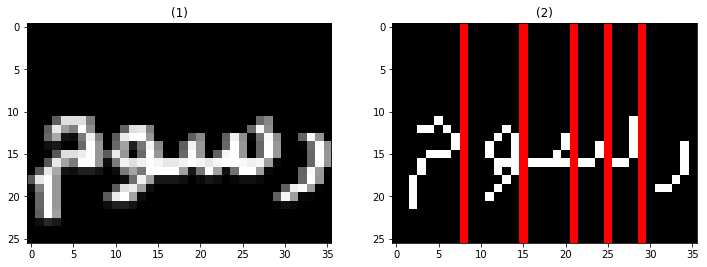

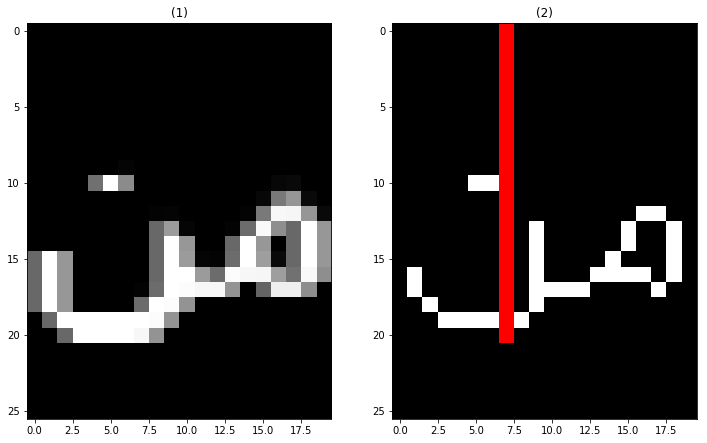

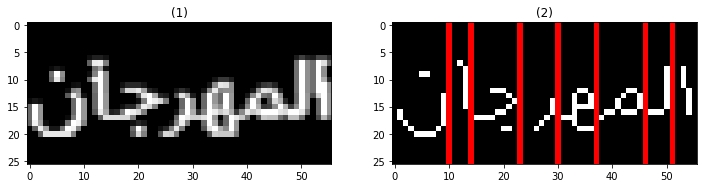

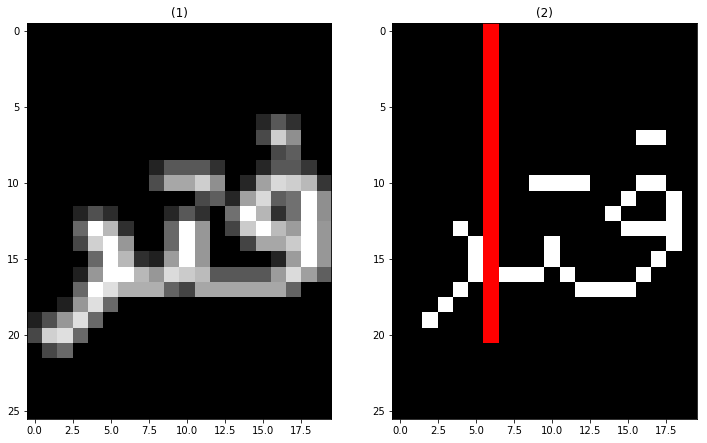

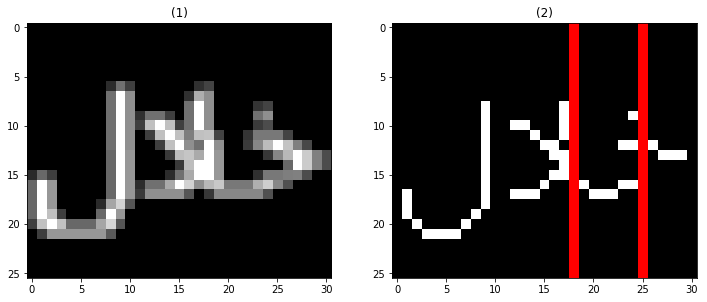

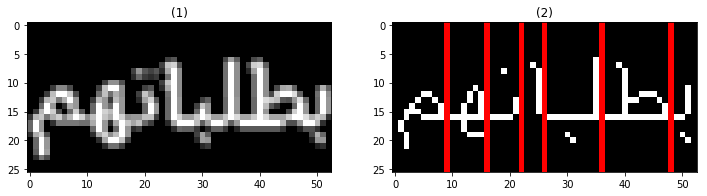

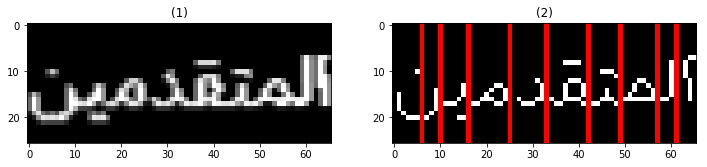

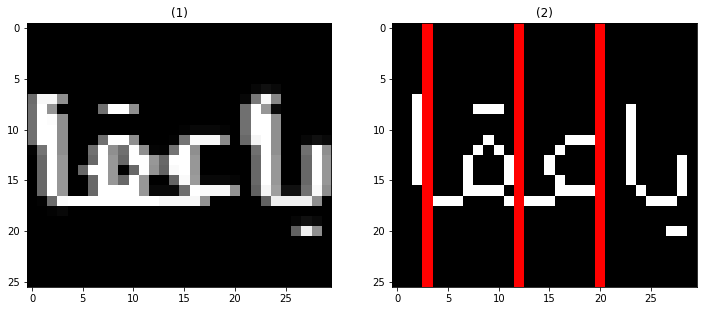

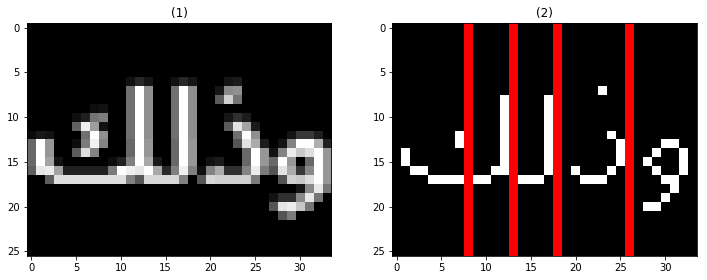

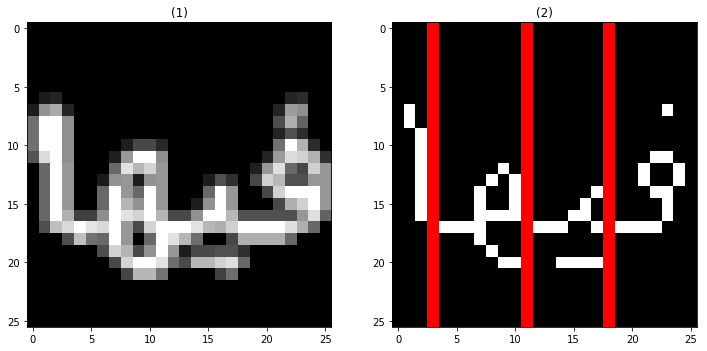

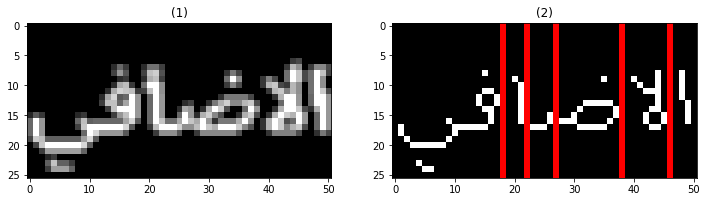

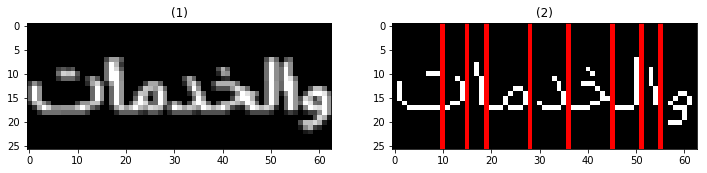

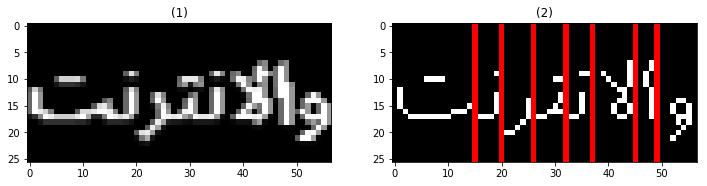

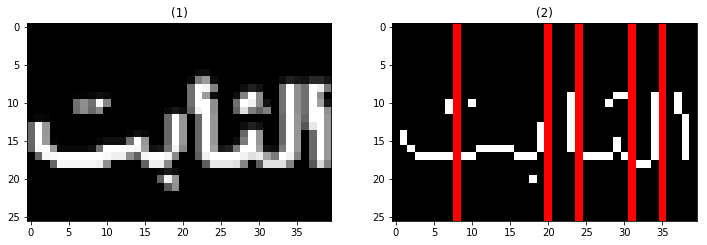

In [76]:
words = breakWords(lines[5])
for word in words:
    show_images([word, segmenteCharacters(word, debug=True)])

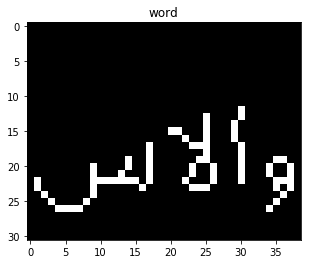

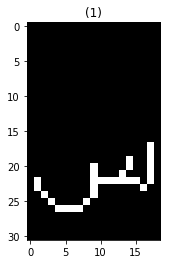

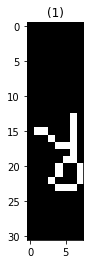

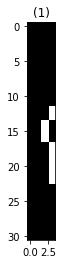

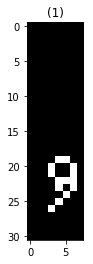

In [21]:
word = words[0]
chars = segmenteCharacters(word)
show_images([toSkeleton(word)], ["word"])
for char in chars:
    show_images([char])

In [72]:
with open('./DataSets/sample/test10/test10.txt') as f:
    text = f.readlines()[0]
    words = text.split()
    for word in words:
        print(word)

الدوح
اف
ب
اعلنت
قنا
الجزير
الفضاي
امس
الاحد
وفا
ماهر
عبدالله
مقدم
برنامج
الشريع
والحيا
ليل
السبت
الاحد
في
حادث
سير
في
مدين
الدوح
وقد
نعت
القنا
اليوم
فقيدها
في
بيان
اكدت
فيه
الحزن
العميق
والاس
لفقدان
الجزير
والاعلام
العربي
ماهر
عبد
الله
مدير
العلاقات
الدولي
في
القنا
ومعد
ومقدم
برنامج
الشريع
والحيا
الذي
يحاور
فيه
اسبوعيا
الداعي
الاسلامي
الشيخ
يوسف
القرضاوي
وقال
شهود
عيان
لوكال
فرانس
برس
ان
سيار
عبد
الله
انحرفت
عن
طريقها
واصطدمت
بنخل
عل
الرصيف
بعد
ان
غادر
الفندق
الذي
التمت
فيه
اجتماعات
المتمر
القومي
العربي
مصطحبا
معه
احد
ضيوف
المتمر
والذي
جرح
في
الحادث
ونقل
ال
المستشف
حيث
قال
اطبا
ان
حالته
مستقر
وعبد
الله
عاما
من
اصل
فلسطيني
وبد
العمل
في
قنا
الجزير
في
بعد
ان
عمل
في
عدد
من
المسسات
الاعلامي
العربي
ومنها
صحيف
الحيا
ومركز
تليفزيون
الشرق
الاوسط
ام
بي
سي
